In [1]:
# all imports
from bs4 import BeautifulSoup as bs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# defining functions

# reads xml-data
def read_data(file):
    with open(file, 'r') as f:
        data = f.read()
    bs_data = bs(data, 'xml') 
    return bs_data


# gets the bname for calculations
def get_bname(path):
    for xml_file in os.listdir(path):
        if xml_file.startswith("timeseries"):
            bs_data = read_data(path + xml_file)
            b_name = bs_data.find_all('name')
            return b_name    


# returns a dataframe given some data
def values_df(bs_data, low, high):
    b_name = bs_data.find_all('name')
    attributes = []
    # finds all values 
    for i in range(len(b_name)):
        attributes.append(b_name[i].get('value'))

    attributes = list(attributes)
    collection = {}
    
    # finds x-, y- and z-values and computes euclidian distance
    for i in range(low, high):
        r = calc(b_name, i)
        collection[attributes[i]] = r

    df = pd.DataFrame(collection)
    return df


# calculates the euclidian values
def calc(b_name, i):
    a1 = b_name[i].find_all('component')[0].get('data')
    b1 = b_name[i].find_all('component')[1].get('data')
    c1 = b_name[i].find_all('component')[2].get('data')
    x = np.asarray([float(x) for x in a1.split(',')])
    y = np.asarray([float(y) for y in b1.split(',')])
    z = np.asarray([float(z) for z in c1.split(',')])
    r = (x**2 + y**2 + z**2)**0.5
    return r


# calculates difference between max and min 
def get_differences_values(path, low, high):
    i = 0
    diff_list = []
    
    for xml_file in os.listdir(path):
        if xml_file.startswith("timeseries"):
            try:
                bs_data = read_data(path + xml_file)
                b_name = bs_data.find_all('name')
                
                # fix since these values for some reason don't work when passed as arguments
                if low >= 3*int(len(b_name)/4):
                    low = 3*int(len(b_name)/4)
                    high = int(len(b_name))
                    
                df1 = values_df(bs_data, low, high)

                df_max = pd.DataFrame(df1.max().to_dict(),index=[df1.index.values[-1]])
                df_min = pd.DataFrame(df1.min().to_dict(),index=[df1.index.values[-1]])
                df1 = df_max.subtract(df_min, fill_value=0)
                df1 = df1.rename(index={100:i})

                diff_list.append(df1)
                i+=1
            except:
                 print(xml_file + " failed to compute")
        else:
            continue
            
    # if healthy, injury level is 0, else it's 1
    if "Healthy" in path:
        injurylevel = [0 for i in range(len(diff_list))]
    else: 
        injurylevel = [1 for i in range(len(diff_list))]
    data_level1 = pd.concat(diff_list)
    data_level1['Injury level'] = injurylevel
    print(f"Length of how many timeseries-files of {path} people we have between files {low} and {high}: {i}")

    return data_level1


In [2]:
# calculate the four power levels for healthy people:
path = "USE THIS/Healthy/"

b_name = get_bname(path)

diff_list1 = get_differences_values(path, 0, int(len(b_name)/4))
diff_list2 = get_differences_values(path, int(len(b_name)/4), int(len(b_name)/2))
diff_list3 = get_differences_values(path, int(len(b_name)/2), int(3*len(b_name)/4))
diff_list4 = get_differences_values(path, int(3*len(b_name)/4), int(len(b_name)))


# calculate the four power levels for injured people:

path = "USE THIS/PFPS/"

diff_list_injured1 = get_differences_values(path, 0, int(len(b_name)/4))
diff_list_injured2 = get_differences_values(path, int(len(b_name)/4), int(len(b_name)/2))
diff_list_injured3 = get_differences_values(path, int(len(b_name)/2), int(3*len(b_name)/4))
diff_list_injured4 = get_differences_values(path, int(3*len(b_name)/4), len(b_name))

# combine the data into the same dataframes


df_healthy = pd.concat([diff_list1, diff_list2, diff_list3, diff_list4])
df_pfps = pd.concat([diff_list_injured1, diff_list_injured2, diff_list_injured3, diff_list_injured4])
df_all = pd.concat([df_healthy, df_pfps])

data3_level1 = pd.concat([diff_list1, diff_list_injured1]).reset_index(drop = True)
data3_level2 = pd.concat([diff_list2, diff_list_injured2]).reset_index(drop = True)
data3_level3 = pd.concat([diff_list3, diff_list_injured3]).reset_index(drop = True)
data3_level4 = pd.concat([diff_list4, diff_list_injured4]).reset_index(drop = True)


timeseries-10.xml failed to compute
timeseries-44.xml failed to compute
Length of how many timeseries-files of USE THIS/Healthy/ people we have between files 0 and 33: 21
timeseries-10.xml failed to compute
Length of how many timeseries-files of USE THIS/Healthy/ people we have between files 33 and 66: 22
timeseries-10.xml failed to compute
timeseries-23.xml failed to compute
Length of how many timeseries-files of USE THIS/Healthy/ people we have between files 66 and 99: 21
timeseries-10.xml failed to compute
timeseries-23.xml failed to compute
Length of how many timeseries-files of USE THIS/Healthy/ people we have between files 93 and 126: 21
Length of how many timeseries-files of USE THIS/PFPS/ people we have between files 0 and 33: 20
Length of how many timeseries-files of USE THIS/PFPS/ people we have between files 33 and 66: 20
Length of how many timeseries-files of USE THIS/PFPS/ people we have between files 66 and 99: 20
Length of how many timeseries-files of USE THIS/PFPS/ peop

# Correlation and covariation matrices

First in the healthy group, then the pfps group, lastly in them both.

Then the same but the covariation matrices :)

<IPython.core.display.Javascript object>


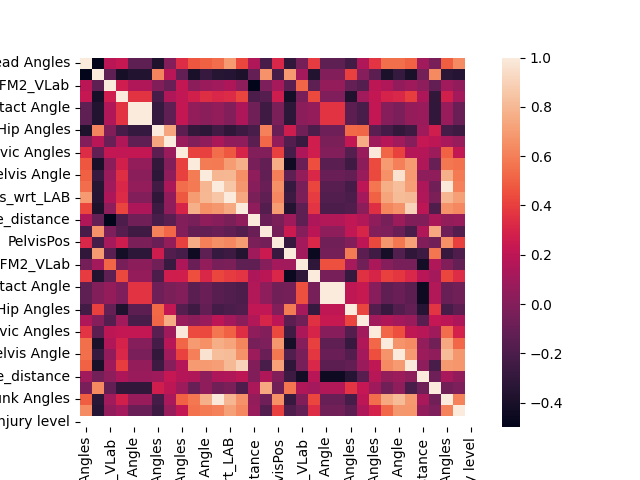

In [31]:
%matplotlib nbagg

corrMatrix = df_healthy.corr()
sns.heatmap(corrMatrix, vmin=-0.5, vmax=1)
plt.show()

<IPython.core.display.Javascript object>


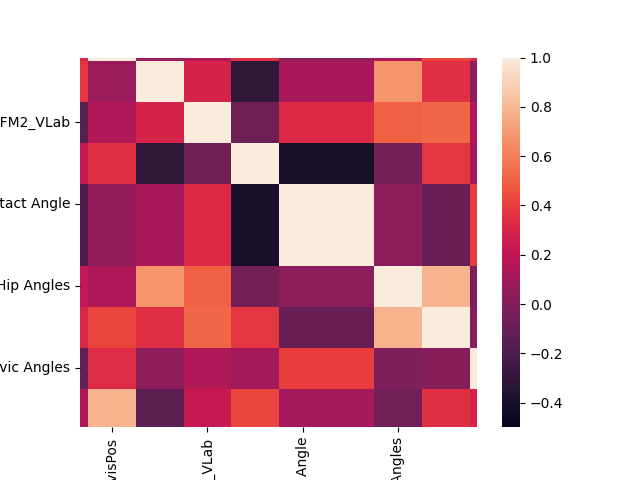

In [57]:
%matplotlib nbagg

corrMatrix = df_pfps.corr()
sns.heatmap(corrMatrix, vmin=-0.5, vmax=1)
plt.show()

<IPython.core.display.Javascript object>


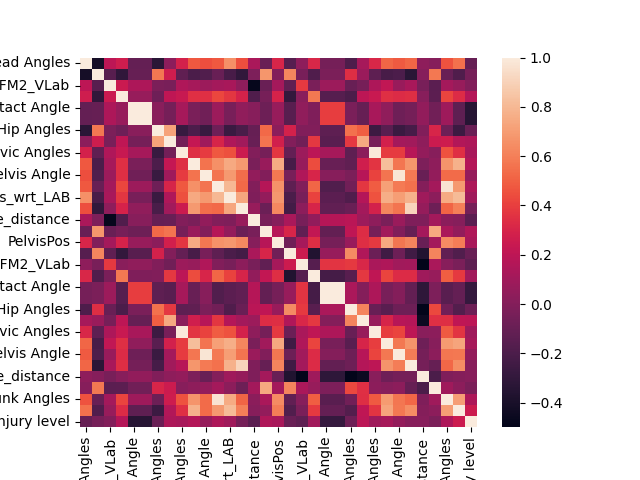

In [33]:
%matplotlib nbagg

corrMatrix = df_all.corr()
sns.heatmap(corrMatrix, vmin=-0.5, vmax=1)
plt.show()

<IPython.core.display.Javascript object>


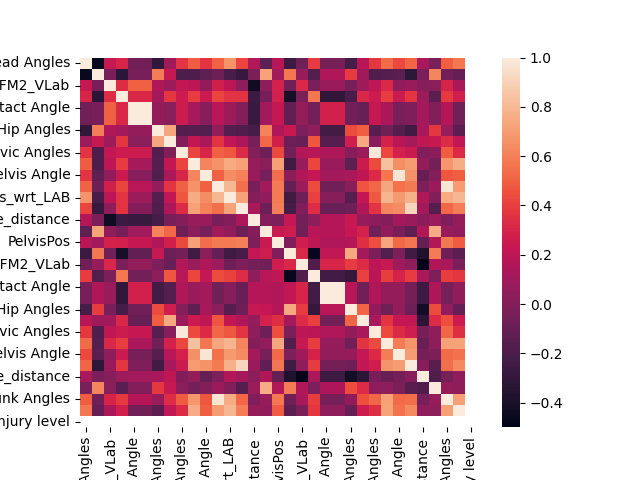

In [56]:
%matplotlib nbagg

df_diff = df_healthy.subtract(df_pfps)
df_clean = df_diff.dropna()
corrMatrix = df_clean.corr()
sns.heatmap(corrMatrix, vmin=-0.5, vmax=1)
plt.show()

<IPython.core.display.Javascript object>


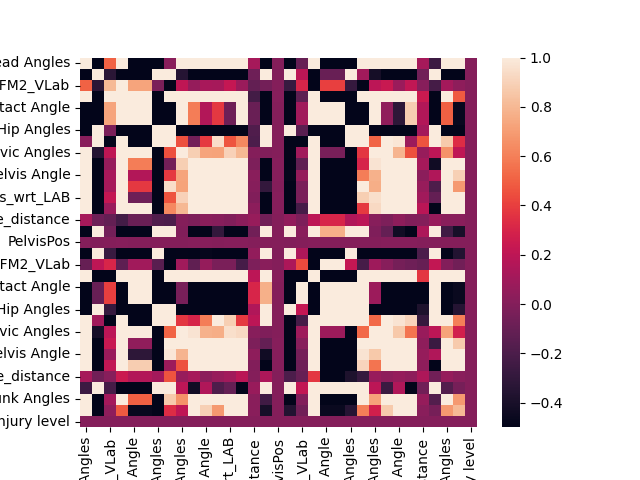

In [34]:
%matplotlib nbagg

covMatrix = df_healthy.cov()
sns.heatmap(covMatrix, vmin=-0.5, vmax=1)
plt.show()

<IPython.core.display.Javascript object>


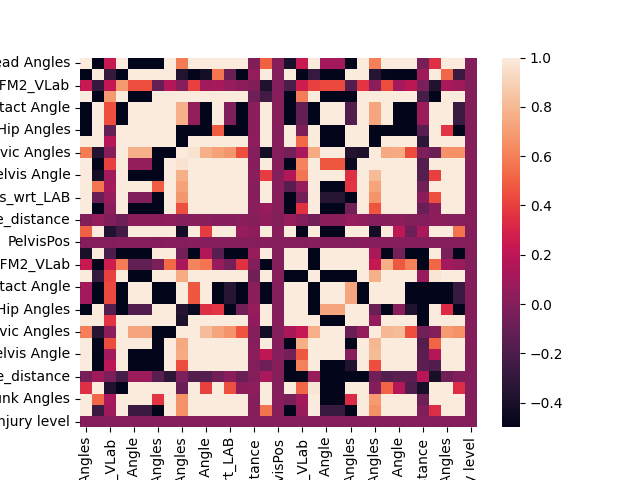

In [35]:
%matplotlib nbagg

covMatrix = df_pfps.cov()
sns.heatmap(covMatrix, vmin=-0.5, vmax=1)
plt.show()

<IPython.core.display.Javascript object>


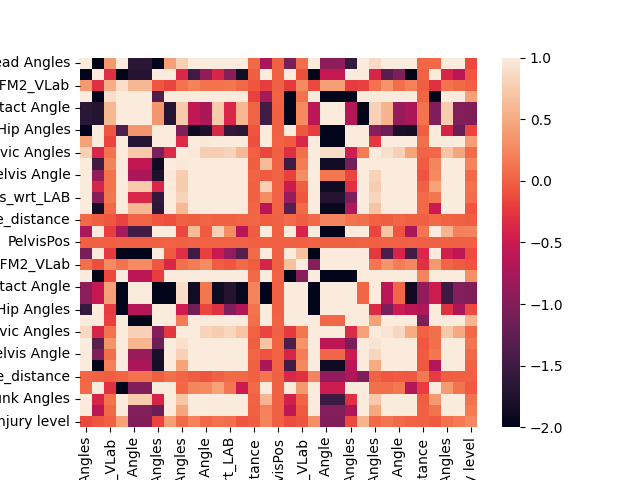

In [42]:
%matplotlib nbagg

covMatrix = df_all.cov()
sns.heatmap(covMatrix, vmin=-2, vmax=1)
plt.show()